<a href="https://colab.research.google.com/github/sarashahin/Badger_AI/blob/main/Badger_Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'project-ai:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4881695%2F8514997%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240530%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240530T110625Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D12ce012de49eed9da3b2c30590d31f3b11318c009b77c2eb0e223968f23344bcb793e2816c2d85bf3f7e6667cad9ee6e03a4bfe3903eaa5849ea695edad58f4f272b402fff790f1e9e152bdf31d83c1047a34eadc87f83eee5c2f9b2efaa2585bd63508839964d4493b56b1f212717c1b254628388901da0f23f700a2b0377003038201d5a0c520edb3f2d03812574a32d6850d9a95fb75cd61143cb0c7bc66076d21d2c7a2d6eb1cb9bbee6db4035451bef660647f95111c83a7fc929497c362043065c7a6010ce69cb85899f84608719317ffc4de73661147d42a02a02363c84cc695c8f9cf330221f186054bf7e2d00c447cd8cd07113760b9915fcba3b7b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

2024-05-25 15:48:06.269289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 15:48:06.269358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 15:48:06.270990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# paths
# dataset_path = '/kaggle/input/project-ai/extracted_frames_zip/extracted_frames_zip'
processed_data_path = '/kaggle/input/project-ai/extracted_frames/extracted_frames'
features_path = '/kaggle/working/features.npy'
clustered_images_path = '/kaggle/working/clustered_images'

# Create directories
os.makedirs(processed_data_path, exist_ok=True)
os.makedirs(clustered_images_path, exist_ok=True)



In [ ]:
def resize_and_normalize_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    # Normalize
    image = image / 255.0
    return image


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone YOLOv5 repository
%cd yolov5
!pip install -r requirements.txt  # install dependencies

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


fatal: destination path 'yolov5' already exists and is not an empty directory.
/kaggle/working/yolov5


In [ ]:
import torch
import os
from PIL import Image, UnidentifiedImageError
import numpy as np

# Load YOLOv5 model (pre-trained on COCO dataset)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Classes to detect
animal_classes = [10, 11, 17, 12, 13, 14, 15, 16, 18, 19]  # COCO classes animals

# for object detection and filtering animal classes
def detect_animals(image_path):
    try:
        results = model(image_path)
        filtered_results = [x for x in results.xyxy[0] if int(x[-1]) in animal_classes]
        return filtered_results
    except Exception as e:
        print(f"Error processing {image_path} in YOLOv5: {e}")
        return []

# for extracting segmented images (animals)
def extract_segmented_images(results, image_path, output_dir):
    try:
        image = Image.open(image_path).convert('RGB')
        for i, (xmin, ymin, xmax, ymax, conf, cls) in enumerate(results):
            xmin, ymin, xmax, ymax = int(xmin.item()), int(ymin.item()), int(xmax.item()), int(ymax.item())
            cropped_image = image.crop((xmin, ymin, xmax, ymax))
            cropped_image.save(f"{output_dir}/{os.path.basename(image_path).split('.')[0]}_seg_{i}.jpg")
    except UnidentifiedImageError:
        print(f"Cannot identify image file {image_path}")
    except Exception as e:
        print(f"Error processing {image_path} during segmentation: {e}")

# directory for segmented images
segmented_images_path = '/kaggle/working/segmented_images'
os.makedirs(segmented_images_path, exist_ok=True)

# Segment images in batches
original_data_path = '/kaggle/input/project-ai/extracted_frames/extracted_frames'
segmented_data = {}

for subdir, _, files in os.walk(original_data_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        # Print the file being processed
        print(f"Processing file: {file_path}")
        # Ensure the file is an image
        try:
            image = Image.open(file_path).convert('RGB')
            results = detect_animals(file_path)
            if results:
                extract_segmented_images(results, file_path, segmented_images_path)
        except (UnidentifiedImageError, IOError) as e:
            print(f"Skipping non-image or corrupted file {file_path}: {e}")
        except Exception as e:
            print(f"Unexpected error for file {file_path}: {e}")






Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-25 Python-3.10.13 torch-2.1.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Processing file: /kaggle/input/project-ai/extracted_frames/extracted_frames/dominate_female_with_cubs_frame_480.jpg
Processing file: /kaggle/input/project-ai/extracted_frames/extracted_frames/IMG_0003_frame_1800.jpg
Processing file: /kaggle/input/project-ai/extracted_frames/extracted_frames/IMG_0014_frame_1380.jpg
Processing file: /kaggle/input/project-ai/extracted_frames/extracted_frames/IMG_0136_frame_240.jpg
Processing file: /kaggle/input/project-ai/extracted_frames/extracted_frames/dominate_female_with_cubs_frame_3000.jpg
Processing file: /kaggle/input/project-ai/extracted_frames/extracted_frames/mum_with_cub_frame_720.jpg
Processing file: /kaggle/input/project-ai/extracted_frames/extracted_frames/IMG_0069_frame_1740.jpg
Processing file: /kaggle/input/project-ai/extracted_frames/extracted_frames/mum_with_cub_frame_2940.jpg
Processing file: /kaggle/input/project-ai/extracted_frames/extracted_frames/IMG_0008_frame_1920.jpg
Processing file: /kaggle/input/project-ai/extracted_frames/ex

In [ ]:
import zipfile

def zip_segmented_images(input_directory, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(input_directory):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, input_directory)
                zipf.write(file_path, arcname)

# paths
processed_data_path = '/kaggle/working/segmented_images'
output_zip_path = '/kaggle/working/segmented_images.zip'

# Zip images
zip_segmented_images(processed_data_path, output_zip_path)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s] 
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 67.2MB/s]


Number of images processed: 255
Shape of combined features: (2000,)
Visualizing features for /kaggle/working/segmented_images/IMG_0079_frame_540_seg_0.jpg


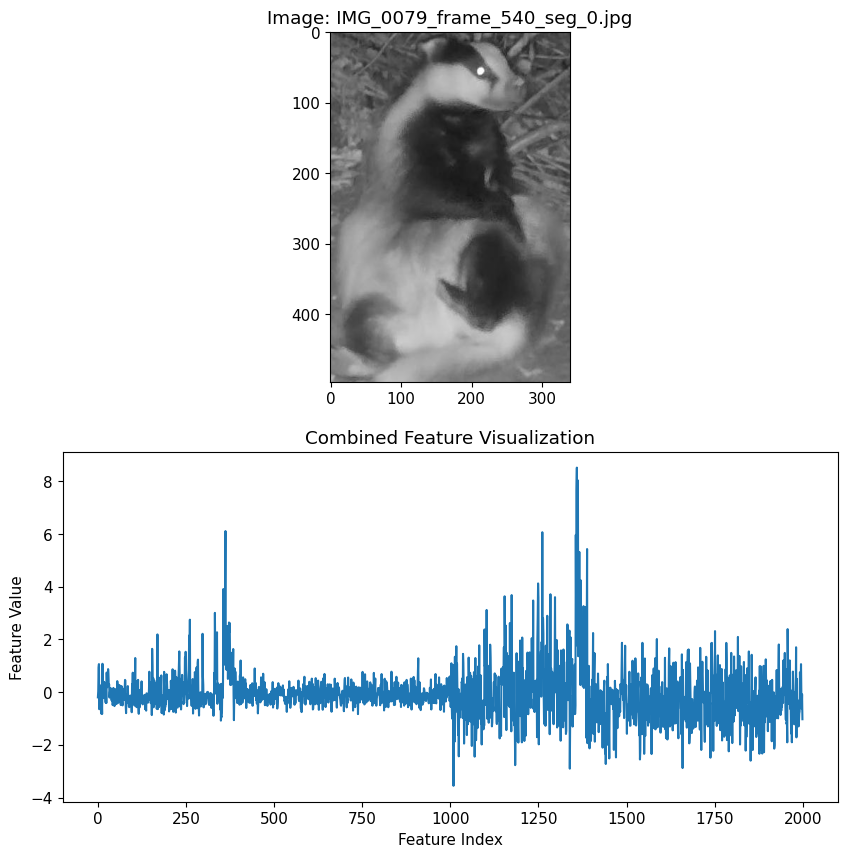

Visualizing features for /kaggle/working/segmented_images/dominate_female_with_cubs_frame_0_seg_0.jpg


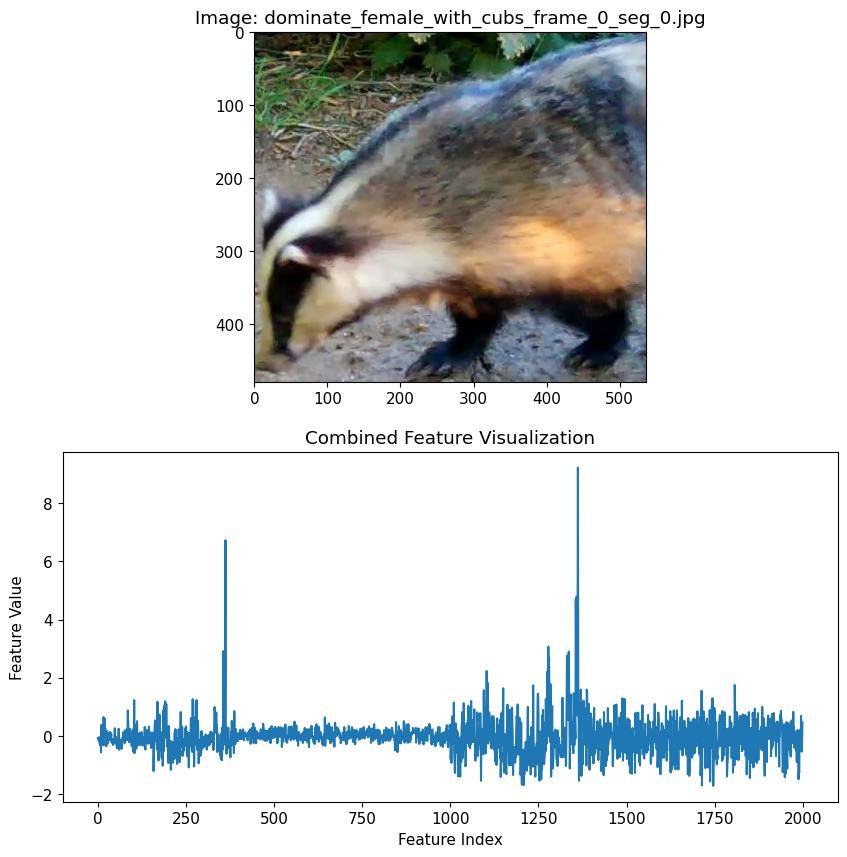

Visualizing features for /kaggle/working/segmented_images/IMG_0079_frame_120_seg_1.jpg


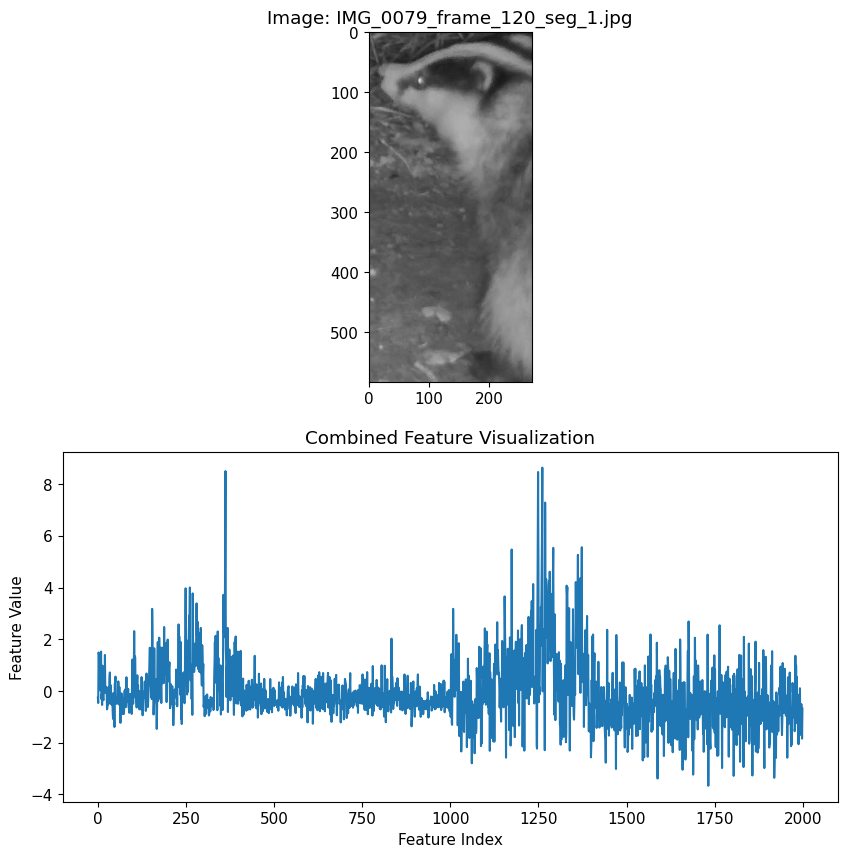

Visualizing features for /kaggle/working/segmented_images/IMG_0023_frame_840_seg_0.jpg


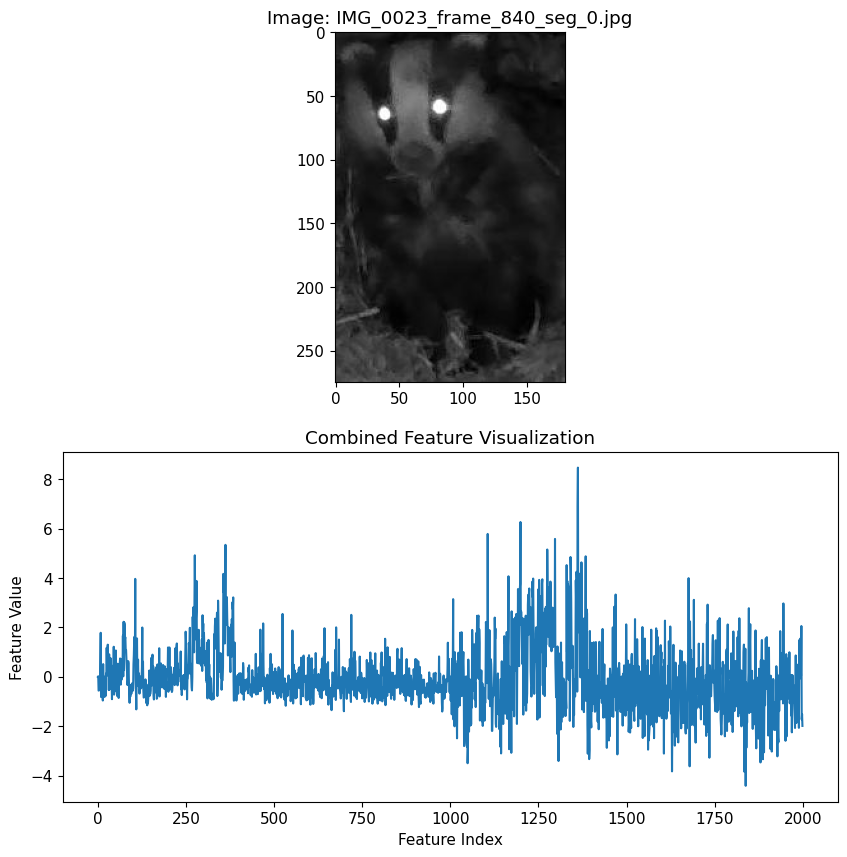

Visualizing features for /kaggle/working/segmented_images/bum_pressing_1_frame_1080_seg_1.jpg


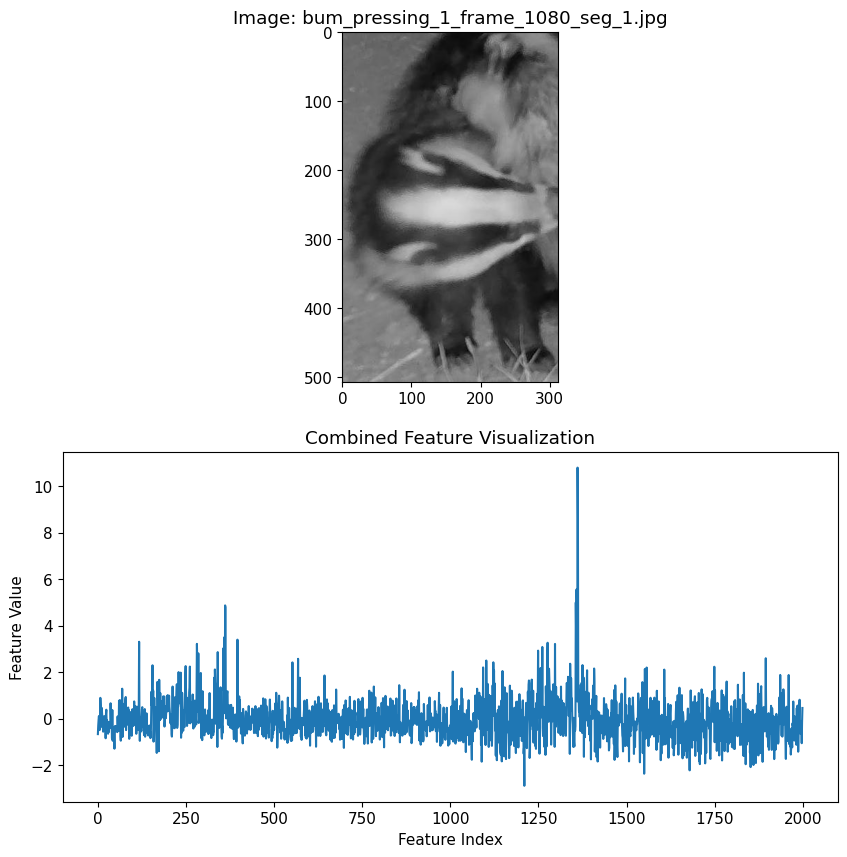

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError
import numpy as np
import os
%matplotlib inline

# Load pre-trained models
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).eval()
efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT).eval()

# image transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# extract features from ResNet50
def extract_resnet_features(image):
    with torch.no_grad():
        resnet_features = resnet_model(image)
    return resnet_features.squeeze().numpy()

#  extract features from EfficientNet
def extract_efficientnet_features(image):
    with torch.no_grad():
        efficientnet_features = efficientnet_model(image)
    return efficientnet_features.squeeze().numpy()

#  extract combined features
def extract_combined_features(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image = preprocess(image).unsqueeze(0)

        resnet_features = extract_resnet_features(image)
        efficientnet_features = extract_efficientnet_features(image)

        combined_features = np.concatenate((resnet_features, efficientnet_features))
        return combined_features
    except (UnidentifiedImageError, IOError) as e:
        print(f"Skipping file {image_path}: {e}")
        return None

# process all images
def extract_all_combined_features(image_directory):
    combined_features = []
    file_names = []
    for subdir, _, files in os.walk(image_directory):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(subdir, file)
                features = extract_combined_features(file_path)
                if features is not None:
                    combined_features.append(features)
                    file_names.append(file_path)
    return combined_features, file_names

segmented_images_path = '/kaggle/working/segmented_images'

# extract combined features from segmented images
combined_features, combined_file_names = extract_all_combined_features(segmented_images_path)

# Save combined features to a file
combined_features_path = '/kaggle/working/combined_features.npy'
np.save(combined_features_path, combined_features)

# Save the corresponding file names
combined_file_names_path = '/kaggle/working/combined_file_names.npy'
np.save(combined_file_names_path, combined_file_names)

# Debugging
print(f"Number of images processed: {len(combined_file_names)}")
if combined_features:
    print(f"Shape of combined features: {combined_features[0].shape if combined_features else 'N/A'}")

# Visualization of features
def visualize_combined_features(features):
    plt.figure(figsize=(10, 5))
    plt.plot(features)
    plt.title('Combined Feature Visualization')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.show()

# visualize the image with extracted features
def visualize_image_and_combined_features(image_path, features):
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.title(f"Image: {os.path.basename(image_path)}")

    plt.subplot(2, 1, 2)
    plt.plot(features)
    plt.title('Combined Feature Visualization')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')

    plt.show()

# Visualize the image and features for the first images
for i in range(min(5, len(combined_features))):
    print(f"Visualizing features for {combined_file_names[i]}")
    visualize_image_and_combined_features(combined_file_names[i], combined_features[i])


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load combined features
local_features_path = '/kaggle/working/combined_features.npy'
local_features = np.load(local_features_path)

# Standardize the features
scaler = StandardScaler()
scaled_local_features = scaler.fit_transform(local_features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(scaled_local_features)

# random subset of the data for faster computation
sample_indices = np.random.choice(len(reduced_features), size=255, replace=False)
sampled_features = reduced_features[sample_indices]


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

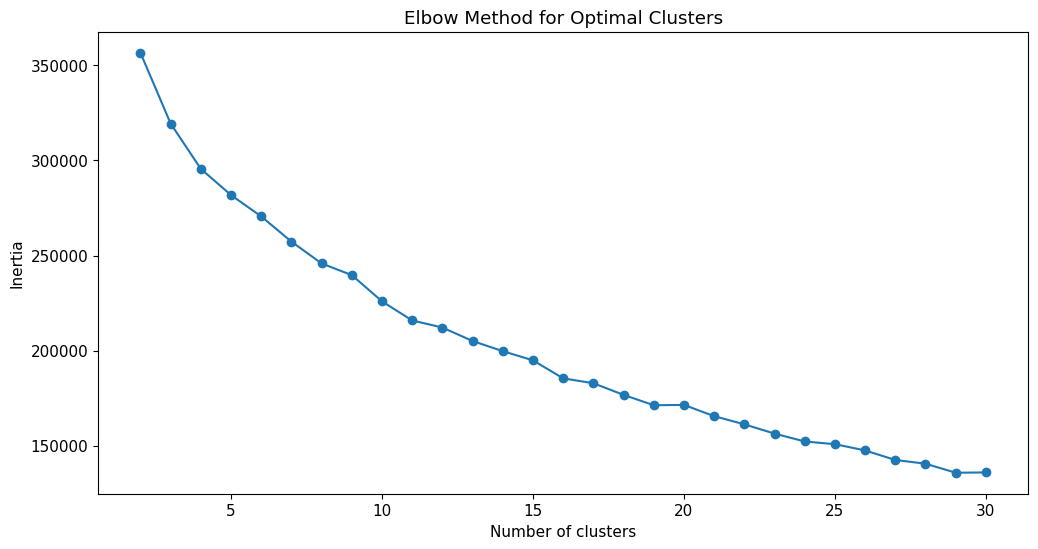

In [ ]:

# optimal clusters using sampled features
def kmeans_inertia(n_clusters, features):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    return kmeans.inertia_

def determine_optimal_clusters(features, max_clusters=30):
    inertias = [kmeans_inertia(n, features) for n in range(2, max_clusters + 1)]

    plt.figure(figsize=(12, 6))
    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Clusters')
    plt.show()

determine_optimal_clusters(sampled_features)



In [ ]:
# K-Means clustering with combined features
n_clusters = 3 #  optimal number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
combined_clusters = kmeans.fit_predict(reduced_features)

# save clustering results for combined features
combined_clusters_path = '/kaggle/working/combined_clusters.npy'
np.save(combined_clusters_path, combined_clusters)

# path to save clustered images
clustered_images_path = '/kaggle/working/clustered_images'
os.makedirs(clustered_images_path, exist_ok=True)

# Save clustering results for combined features
for i, cluster_id in enumerate(combined_clusters):
    cluster_dir = os.path.join(clustered_images_path, f'cluster_{cluster_id}')
    os.makedirs(cluster_dir, exist_ok=True)
    file_name = os.path.basename(combined_file_names[i])
    image = Image.open(combined_file_names[i])
    image.save(os.path.join(cluster_dir, file_name))

# Debugging
print(f"Number of images clustered: {len(combined_clusters)}")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of images clustered: 255


Silhouette Score: 0.20930856466293335
Visualizing combined features for /kaggle/working/segmented_images/IMG_0079_frame_540_seg_0.jpg


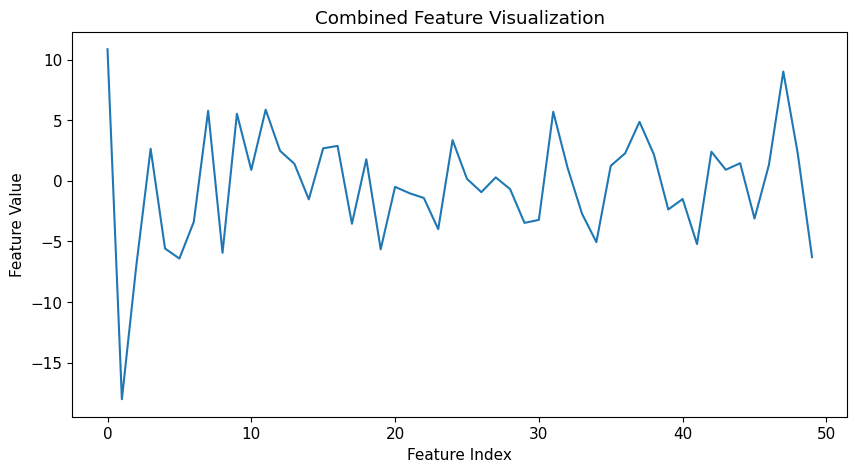

Visualizing combined features for /kaggle/working/segmented_images/dominate_female_with_cubs_frame_0_seg_0.jpg


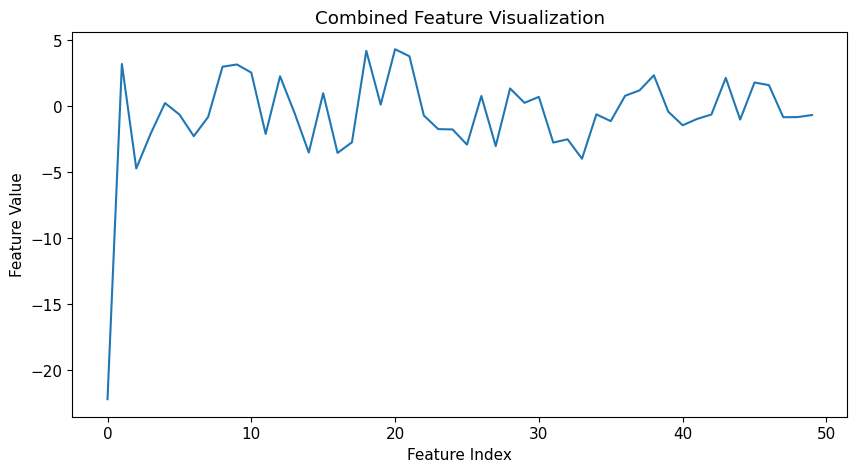

Visualizing combined features for /kaggle/working/segmented_images/IMG_0079_frame_120_seg_1.jpg


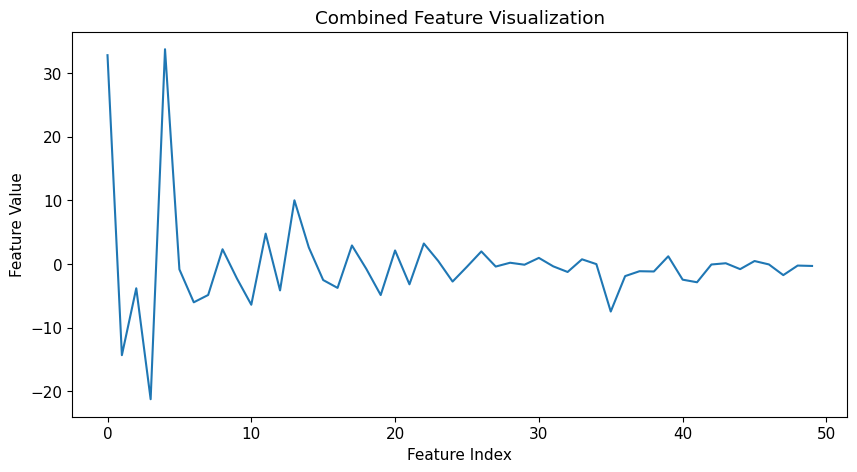

Visualizing combined features for /kaggle/working/segmented_images/IMG_0023_frame_840_seg_0.jpg


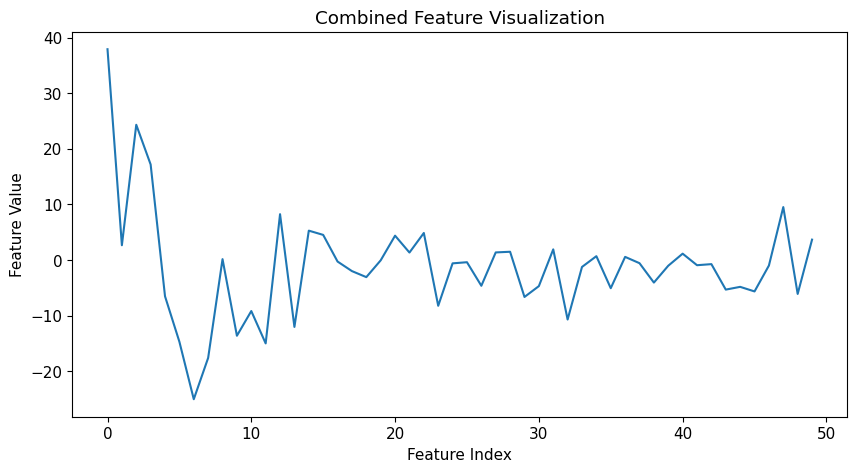

Visualizing combined features for /kaggle/working/segmented_images/bum_pressing_1_frame_1080_seg_1.jpg


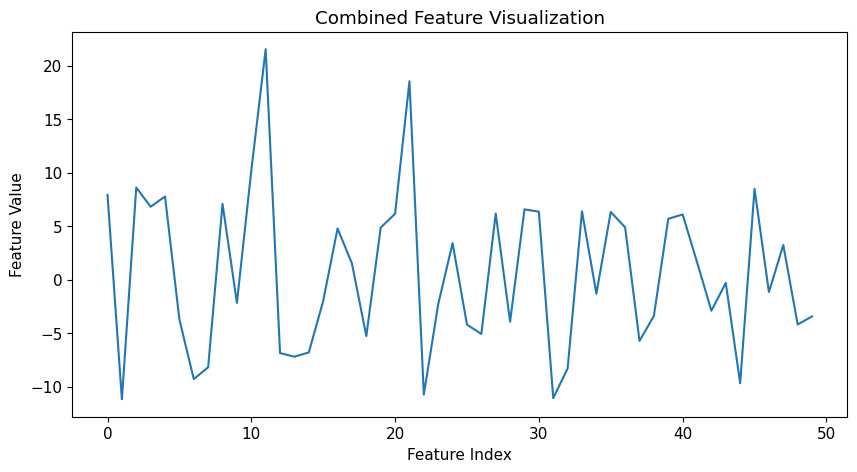

Visualizing samples from cluster 0


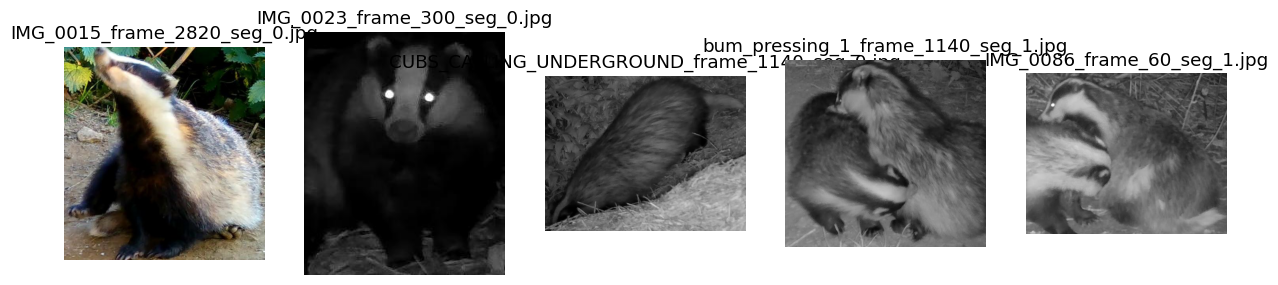

Visualizing samples from cluster 1


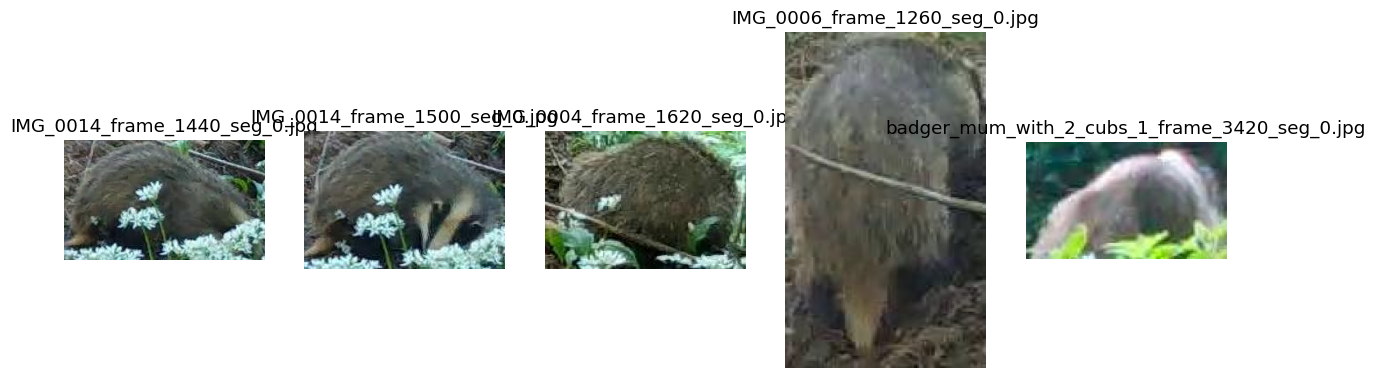

Visualizing samples from cluster 2


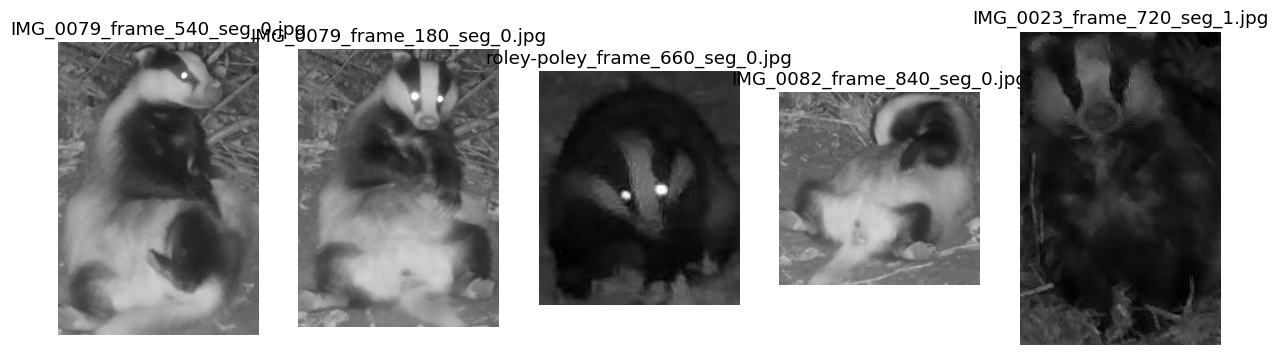

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate and print silhouette score
sil_score = silhouette_score(reduced_features, combined_clusters)
print(f'Silhouette Score: {sil_score}')

# Visualization of features
def visualize_combined_features(features):
    plt.figure(figsize=(10, 5))
    plt.plot(features)
    plt.title('Combined Feature Visualization')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.show()

# Visualize combined features for the first images
for i in range(min(5, len(reduced_features))):
    print(f"Visualizing combined features for {combined_file_names[i]}")
    visualize_combined_features(reduced_features[i])

# visualize images in clusters
def visualize_cluster_samples(cluster_dir, n_samples=5):
    cluster_files = [os.path.join(cluster_dir, f) for f in os.listdir(cluster_dir) if f.endswith('.jpg')]
    plt.figure(figsize=(15, 10))
    for i, file in enumerate(np.random.choice(cluster_files, size=n_samples, replace=False)):
        plt.subplot(1, n_samples, i+1)
        image = Image.open(file)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"{os.path.basename(file)}")
    plt.show()

# Visualize a few each cluster
for cluster_id in range(n_clusters):
    cluster_dir = os.path.join(clustered_images_path, f'cluster_{cluster_id}')
    print(f"Visualizing samples from cluster {cluster_id}")
    visualize_cluster_samples(cluster_dir)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_score

def cross_val_clustering(features, n_clusters, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    scores = []
    for train_index, test_index in skf.split(features, np.zeros(features.shape[0])):
        train_features, test_features = features[train_index], features[test_index]
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(train_features)
        labels = kmeans.predict(test_features)
        score = silhouette_score(test_features, labels)
        scores.append(score)
    return np.mean(scores), np.std(scores)

mean_score, std_score = cross_val_clustering(reduced_features, n_clusters=5)
print(f'Mean Silhouette Score: {mean_score}, Std Silhouette Score: {std_score}')


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Mean Silhouette Score: 0.1936507523059845, Std Silhouette Score: 0.06318887323141098


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.offsetbox as offsetbox

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN

#  tune DBSCAN parameters
def tune_dbscan(features, eps_values, min_samples_values):
    best_sil_score = -1
    best_params = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(features)
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

            if n_clusters > 1:
                sil_score = silhouette_score(features, clusters)
                if sil_score > best_sil_score:
                    best_sil_score = sil_score
                    best_params = (eps, min_samples)
                    print(f"New best params: eps={eps}, min_samples={min_samples}, silhouette score={sil_score}")

    return best_params, best_sil_score

# Tune DBSCAN parameters
eps_values = np.linspace(0.1, 10, 25, 30)
min_samples_values = range(2, 10)
best_params, best_sil_score = tune_dbscan(reduced_features, eps_values, min_samples_values)

# DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
dbscan_clusters = dbscan.fit_predict(reduced_features)

# Evaluate DBSCAN clusters
davies_bouldin = davies_bouldin_score(reduced_features, dbscan_clusters)
calinski_harabasz = calinski_harabasz_score(reduced_features, dbscan_clusters)

print(f'DBSCAN - Silhouette Score: {best_sil_score}')
print(f'DBSCAN - Davies-Bouldin Index: {davies_bouldin}')
print(f'DBSCAN - Calinski-Harabasz Index: {calinski_harabasz}')


New best params: eps=2.9875000000000003, min_samples=2, silhouette score=-0.22556783258914948
New best params: eps=8.762500000000001, min_samples=2, silhouette score=-0.20579800009727478
New best params: eps=9.175, min_samples=2, silhouette score=-0.20187188684940338
New best params: eps=9.5875, min_samples=2, silhouette score=-0.1922135055065155
New best params: eps=10.0, min_samples=2, silhouette score=-0.1837230771780014
DBSCAN - Silhouette Score: -0.1837230771780014
DBSCAN - Davies-Bouldin Index: 1.402325151888446
DBSCAN - Calinski-Harabasz Index: 1.689902764201213


In [ ]:
!pip install hdbscan

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 44.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [ ]:
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(reduced_features)

# HDBSCAN clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=5)
hdbscan_clusters = hdbscan_model.fit_predict(scaled_features)

# Evaluate HDBSCAN clusters
n_clusters = len(set(hdbscan_clusters)) - (1 if -1 in hdbscan_clusters else 0)

if n_clusters > 1:
    sil_score = silhouette_score(scaled_features, hdbscan_clusters)
    davies_bouldin = davies_bouldin_score(scaled_features, hdbscan_clusters)
    calinski_harabasz = calinski_harabasz_score(scaled_features, hdbscan_clusters)

    print(f'HDBSCAN - Number of clusters: {n_clusters}')
    print(f'HDBSCAN - Silhouette Score: {sil_score}')
    print(f'HDBSCAN - Davies-Bouldin Index: {davies_bouldin}')
    print(f'HDBSCAN - Calinski-Harabasz Index: {calinski_harabasz}')
else:
    print("HDBSCAN did not find more than one cluster.")


HDBSCAN - Number of clusters: 2
HDBSCAN - Silhouette Score: -0.06080721691250801
HDBSCAN - Davies-Bouldin Index: 5.078249987344676
HDBSCAN - Calinski-Harabasz Index: 4.326018110978881


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=20)
agglo_clusters = agglo.fit_predict(reduced_features)

# Evaluate Agglomerative Clustering
sil_score = silhouette_score(reduced_features, agglo_clusters)
davies_bouldin = davies_bouldin_score(reduced_features, agglo_clusters)
calinski_harabasz = calinski_harabasz_score(reduced_features, agglo_clusters)

print(f'Agglomerative Clustering - Silhouette Score: {sil_score}')
print(f'Agglomerative Clustering - Davies-Bouldin Index: {davies_bouldin}')
print(f'Agglomerative Clustering - Calinski-Harabasz Index: {calinski_harabasz}')

Agglomerative Clustering - Silhouette Score: 0.1559557467699051
Agglomerative Clustering - Davies-Bouldin Index: 1.576103182732606
Agglomerative Clustering - Calinski-Harabasz Index: 18.38243057463502


In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

davies_bouldin = davies_bouldin_score(reduced_features, combined_clusters)
calinski_harabasz = calinski_harabasz_score(reduced_features, combined_clusters)

print(f'Davies-Bouldin Index: {davies_bouldin}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')


Davies-Bouldin Index: 1.890801486503786
Calinski-Harabasz Index: 20.689529787308704


In [ ]:
def cluster_stability(features, n_clusters, n_init=10):
    inertias = []
    for _ in range(n_init):
        kmeans = KMeans(n_clusters=n_clusters, random_state=np.random.randint(10000))
        kmeans.fit(features)
        inertias.append(kmeans.inertia_)
    return np.mean(inertias), np.std(inertias)

mean_inertia, std_inertia = cluster_stability(reduced_features, n_clusters)
print(f'Cluster Stability: Mean Inertia={mean_inertia}, Std Inertia={std_inertia}')

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Cluster Stability: Mean Inertia=356690.73125, Std Inertia=2.7249999999999996


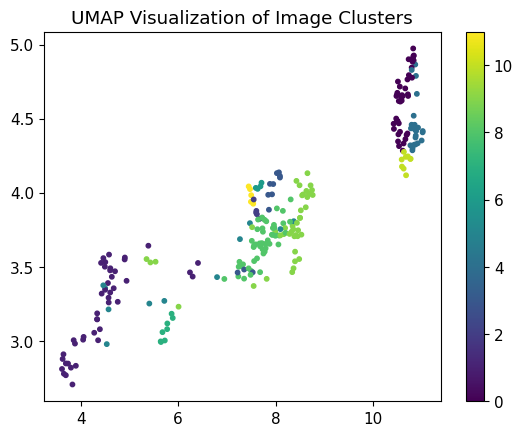

In [ ]:
import umap

umap_reducer = umap.UMAP(n_components=12, random_state=42)
umap_results = umap_reducer.fit_transform(scaled_local_features)

plt.scatter(umap_results[:, 0], umap_results[:, 1], c=combined_clusters, cmap='viridis', s=10)
plt.colorbar()
plt.title('UMAP Visualization of Image Clusters')
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


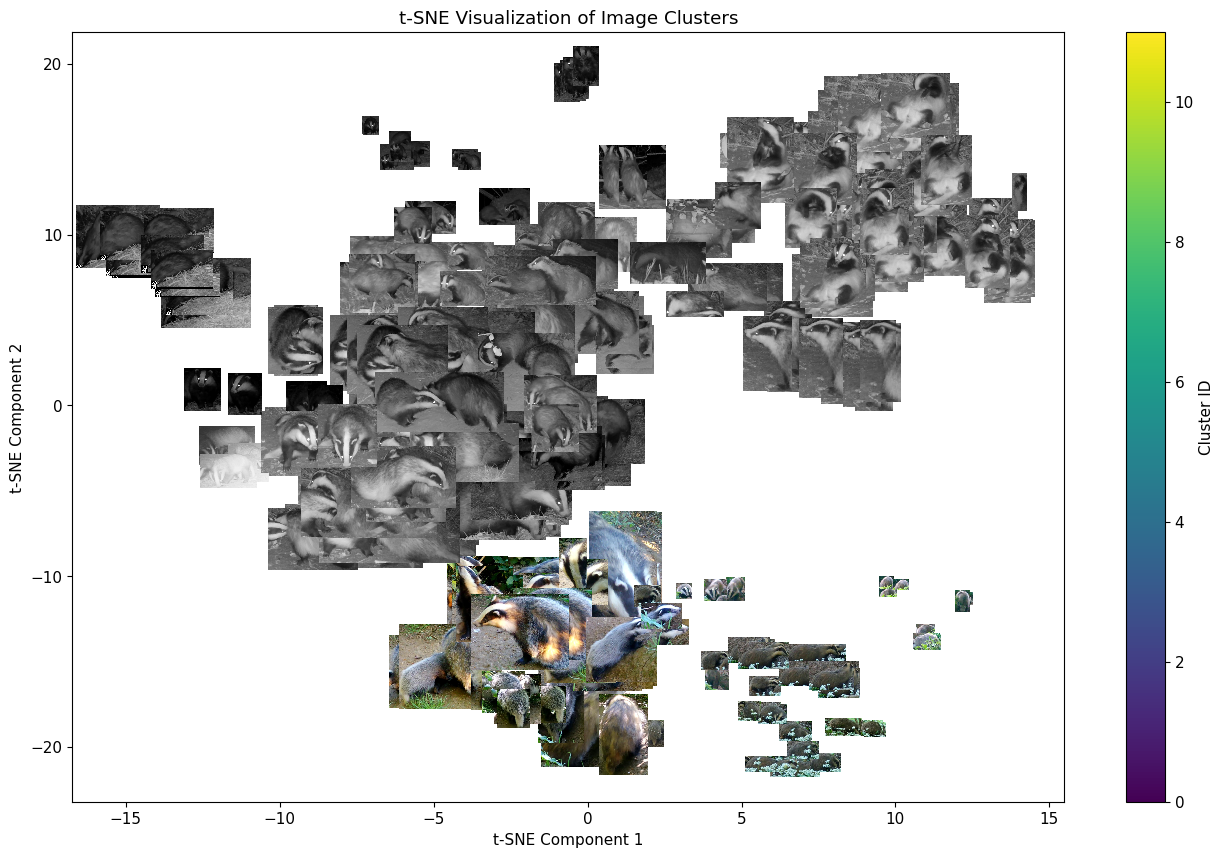

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
from PIL import Image

# K-Means clustering with combined features
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
combined_clusters = kmeans.fit_predict(reduced_features)

#  t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_features)

# scatter plot of t-SNE results with images
fig, ax = plt.subplots(figsize=(16, 10))

# Scatter plot with cluster colors
scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=combined_clusters, cmap='viridis', s=10)

# plot images on the scatter plot
def plot_images_on_scatter(images, coords, ax, zoom=0.1):
    for i in range(len(images)):
        img = Image.open(images[i])
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img, zoom=zoom),
            coords[i],
            frameon=False
        )
        ax.add_artist(imagebox)

# Plot images on the scatter plot
plot_images_on_scatter(combined_file_names, tsne_results, ax)

# color bar to show the cluster IDs
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster ID')

plt.title('t-SNE Visualization of Image Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# the parameter grid
param_grid = {'n_clusters': range(10, 30)}

# Custom silhouette scoring function
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)

# Initialize KMeans
kmeans = KMeans(random_state=42)

# GridSearchCV with the custom silhouette score
grid_search = GridSearchCV(kmeans, param_grid, scoring=silhouette_scorer)

# Fit the model to the reduced features
grid_search.fit(reduced_features)

# Print the best number of clusters
print(f'Best number of clusters: {grid_search.best_params_}')

# Apply K-Means clustering with the best number of clusters
best_n_clusters = grid_search.best_params_['n_clusters']
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
combined_clusters = kmeans.fit_predict(reduced_features)

# Save clustering results for combined features
combined_clusters_path = '/kaggle/working/combined_clusters.npy'
np.save(combined_clusters_path, combined_clusters)

# path to save clustered images
clustered_images_path = '/kaggle/working/clustered_images'
os.makedirs(clustered_images_path, exist_ok=True)

# Save clustering results for combined features
for i, cluster_id in enumerate(combined_clusters):
    cluster_dir = os.path.join(clustered_images_path, f'cluster_{cluster_id}')
    os.makedirs(cluster_dir, exist_ok=True)
    file_name = os.path.basename(combined_file_names[i])
    image = Image.open(combined_file_names[i])
    image.save(os.path.join(cluster_dir, file_name))

# Debugging
print(f"Number of images clustered: {len(combined_clusters)}")




/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Best number of clusters: {'n_clusters': 12}


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of images clustered: 255
